# Task 1: Exploratory Data Analysis & Preprocessing

This notebook performs EDA on the CFPB complaints dataset and prepares a filtered, cleaned dataset for the RAG pipeline.

## Objectives
1. Understand the structure and quality of the complaint data
2. Analyze product distribution
3. Analyze narrative availability and length
4. Filter to 5 target products
5. Clean text narratives
6. Save filtered dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Paths
RAW_DATA_PATH = Path('../data/raw/complaints.csv')
OUTPUT_PATH = Path('../data/filtered_complaints.csv')

print(f"Raw data path: {RAW_DATA_PATH}")
print(f"Output path: {OUTPUT_PATH}")

Raw data path: ../data/raw/complaints.csv
Output path: ../data/filtered_complaints.csv


## 1. Load and Inspect Data

In [2]:
# Load only the columns we need (memory efficient for 6GB file)
usecols = [
    'Complaint ID',
    'Product',
    'Sub-product',
    'Issue',
    'Sub-issue',
    'Consumer complaint narrative',
    'Company',
    'Date received'
]

print("Loading dataset (this may take a few minutes for 6GB file)...")
df = pd.read_csv(
    RAW_DATA_PATH,
    usecols=usecols,
    dtype={
        'Product': 'string',
        'Sub-product': 'string',
        'Consumer complaint narrative': 'string',
        'Issue': 'string',
        'Company': 'string'
    }
)
print(f"Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")

Loading dataset (this may take a few minutes for 6GB file)...
Dataset loaded: 9,609,797 rows, 8 columns


In [3]:
# Basic info
print("=" * 50)
print("DATASET OVERVIEW")
print("=" * 50)
print(f"\nShape: {df.shape}")
print(f"\nColumn types:")
print(df.dtypes)
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")

DATASET OVERVIEW

Shape: (9609797, 8)

Column types:
Date received                           object
Product                         string[python]
Sub-product                     string[python]
Issue                           string[python]
Sub-issue                               object
Consumer complaint narrative    string[python]
Company                         string[python]
Complaint ID                             int64
dtype: object

Memory usage: 8.09 GB


In [4]:
# Missing values
print("\nMissing values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
print(missing_df)


Missing values:
                              Missing  Percent
Date received                       0     0.00
Product                             0     0.00
Sub-product                    235295     2.45
Issue                               6     0.00
Sub-issue                      839522     8.74
Consumer complaint narrative  6629041    68.98
Company                             0     0.00
Complaint ID                        0     0.00


## 2. Product Distribution Analysis

In [5]:
# Product distribution
print("\n" + "=" * 50)
print("PRODUCT DISTRIBUTION")
print("=" * 50)

product_counts = df['Product'].value_counts(dropna=False)
print(f"\nUnique products: {df['Product'].nunique()}")
print(f"\nAll products and their counts:")
for product, count in product_counts.items():
    pct = count / len(df) * 100
    print(f"  {product}: {count:,} ({pct:.2f}%)")


PRODUCT DISTRIBUTION

Unique products: 21

All products and their counts:
  Credit reporting or other personal consumer reports: 4,834,855 (50.31%)
  Credit reporting, credit repair services, or other personal consumer reports: 2,163,857 (22.52%)
  Debt collection: 799,197 (8.32%)
  Mortgage: 422,254 (4.39%)
  Checking or savings account: 291,178 (3.03%)
  Credit card: 226,686 (2.36%)
  Credit card or prepaid card: 206,369 (2.15%)
  Money transfer, virtual currency, or money service: 145,066 (1.51%)
  Credit reporting: 140,429 (1.46%)
  Student loan: 109,717 (1.14%)
  Bank account or service: 86,205 (0.90%)
  Vehicle loan or lease: 72,957 (0.76%)
  Consumer Loan: 31,574 (0.33%)
  Payday loan, title loan, or personal loan: 30,641 (0.32%)
  Payday loan, title loan, personal loan, or advance loan: 16,514 (0.17%)
  Prepaid card: 15,280 (0.16%)
  Payday loan: 5,541 (0.06%)
  Money transfers: 5,354 (0.06%)
  Debt or credit management: 5,047 (0.05%)
  Other financial service: 1,058 (0.01%)
 

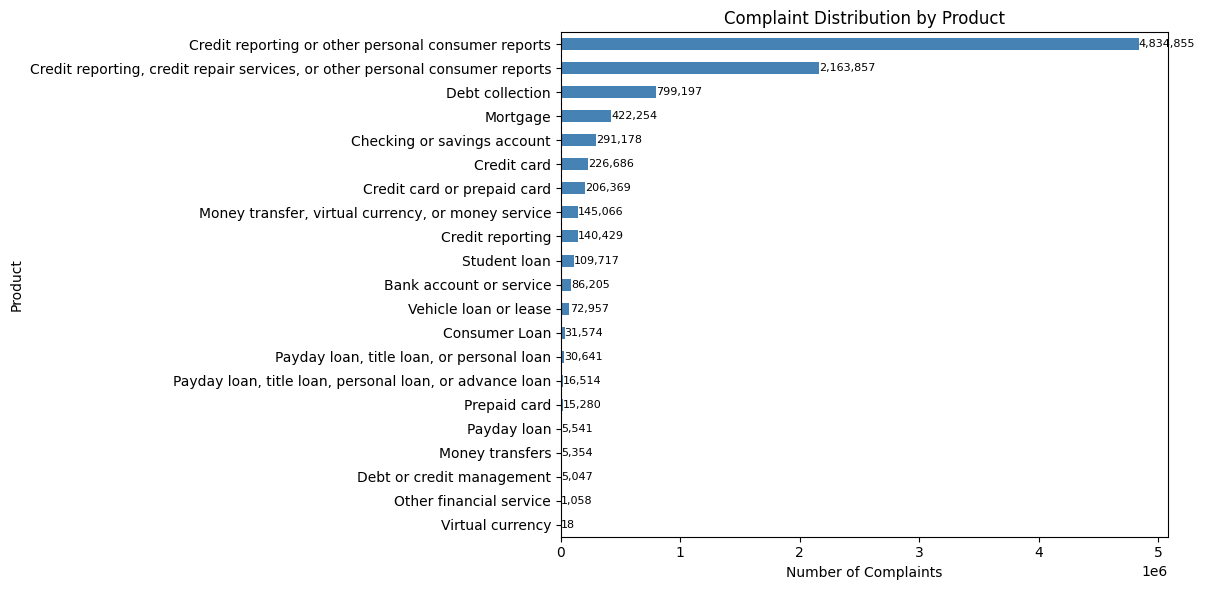

In [6]:
# Visualize product distribution
fig, ax = plt.subplots(figsize=(12, 6))
product_counts.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Number of Complaints')
ax.set_ylabel('Product')
ax.set_title('Complaint Distribution by Product')
ax.invert_yaxis()
for i, (count, product) in enumerate(zip(product_counts.values, product_counts.index)):
    ax.text(count + 1000, i, f'{count:,}', va='center', fontsize=8)
plt.tight_layout()
plt.savefig('../notebooks/product_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Identify Target Products

We need to map CFPB product names to our 5 target categories:
- Credit card
- Personal loan (may be under "Consumer Loan" or "Payday loan")
- BNPL (Buy Now, Pay Later) - may not exist as separate category
- Savings account (under "Bank account or service" or "Checking or savings account")
- Money transfers

In [7]:
# Check sub-products for more granular mapping
print("\nSub-products breakdown for key categories:")

for product in ['Credit card', 'Credit card or prepaid card', 'Consumer Loan', 
                'Payday loan', 'Bank account or service', 'Checking or savings account',
                'Money transfer, virtual currency, or money service', 'Money transfers']:
    if product in df['Product'].values:
        print(f"\n{product}:")
        sub_counts = df[df['Product'] == product]['Sub-product'].value_counts().head(10)
        for sub, count in sub_counts.items():
            print(f"  - {sub}: {count:,}")


Sub-products breakdown for key categories:

Credit card:
  - General-purpose credit card or charge card: 123,045
  - Store credit card: 14,452

Credit card or prepaid card:
  - General-purpose credit card or charge card: 158,886
  - Store credit card: 27,910
  - Government benefit card: 9,068
  - General-purpose prepaid card: 8,531
  - Gift card: 1,021
  - Payroll card: 918
  - Student prepaid card: 32

Consumer Loan:
  - Vehicle loan: 17,779
  - Installment loan: 8,675
  - Vehicle lease: 2,655
  - Personal line of credit: 1,824
  - Title loan: 547
  - Pawn loan: 94

Payday loan:

Bank account or service:
  - Checking account: 59,044
  - Other bank product/service: 17,825
  - Savings account: 5,294
  - (CD) Certificate of deposit: 3,417
  - Cashing a check without an account: 625

Checking or savings account:
  - Checking account: 234,253
  - Other banking product or service: 27,998
  - Savings account: 22,406
  - CD (Certificate of Deposit): 6,421
  - Credit reporting: 1

Money trans

In [8]:
# Define product mapping based on CFPB categories
# This maps CFPB product names to our standardized categories

PRODUCT_MAPPING = {
    # Credit Card
    'Credit card': 'credit_card',
    'Credit card or prepaid card': 'credit_card',
    
    # Personal Loan
    'Consumer Loan': 'personal_loan',
    'Payday loan': 'personal_loan',
    'Payday loan, title loan, or personal loan': 'personal_loan',
    'Payday loan, title loan, personal loan, or advance app': 'personal_loan',
    
    # Savings Account
    'Bank account or service': 'savings_account',
    'Checking or savings account': 'savings_account',
    
    # Money Transfers
    'Money transfers': 'money_transfer',
    'Money transfer, virtual currency, or money service': 'money_transfer',
}

# Note: BNPL is relatively new and may not have a dedicated category in older CFPB data
# It might be under personal loans or a specific sub-product

print("Product mapping defined:")
for cfpb_name, our_name in PRODUCT_MAPPING.items():
    print(f"  '{cfpb_name}' -> '{our_name}'")

Product mapping defined:
  'Credit card' -> 'credit_card'
  'Credit card or prepaid card' -> 'credit_card'
  'Consumer Loan' -> 'personal_loan'
  'Payday loan' -> 'personal_loan'
  'Payday loan, title loan, or personal loan' -> 'personal_loan'
  'Payday loan, title loan, personal loan, or advance app' -> 'personal_loan'
  'Bank account or service' -> 'savings_account'
  'Checking or savings account' -> 'savings_account'
  'Money transfers' -> 'money_transfer'
  'Money transfer, virtual currency, or money service' -> 'money_transfer'


## 4. Narrative Availability Analysis

In [9]:
print("\n" + "=" * 50)
print("NARRATIVE AVAILABILITY")
print("=" * 50)

# Check narrative availability
n_total = len(df)
n_null = df['Consumer complaint narrative'].isna().sum()
n_empty = (df['Consumer complaint narrative'].fillna('').str.strip() == '').sum()
n_with_narrative = n_total - n_empty

print(f"\nTotal complaints: {n_total:,}")
print(f"With narrative: {n_with_narrative:,} ({n_with_narrative/n_total*100:.2f}%)")
print(f"Null narratives: {n_null:,} ({n_null/n_total*100:.2f}%)")
print(f"Empty narratives (after strip): {n_empty:,} ({n_empty/n_total*100:.2f}%)")


NARRATIVE AVAILABILITY

Total complaints: 9,609,797
With narrative: 2,980,756 (31.02%)
Null narratives: 6,629,041 (68.98%)
Empty narratives (after strip): 6,629,041 (68.98%)


In [10]:
# Narrative availability by product
print("\nNarrative availability by product:")

df['has_narrative'] = df['Consumer complaint narrative'].fillna('').str.strip() != ''

narrative_by_product = df.groupby('Product').agg(
    total=('has_narrative', 'count'),
    with_narrative=('has_narrative', 'sum')
).reset_index()
narrative_by_product['pct_with_narrative'] = (narrative_by_product['with_narrative'] / narrative_by_product['total'] * 100).round(2)
narrative_by_product = narrative_by_product.sort_values('total', ascending=False)

print(narrative_by_product.to_string(index=False))


Narrative availability by product:
                                                                     Product   total  with_narrative  pct_with_narrative
                         Credit reporting or other personal consumer reports 4834855         1091253               22.57
Credit reporting, credit repair services, or other personal consumer reports 2163857          807281               37.31
                                                             Debt collection  799197          336076               42.05
                                                                    Mortgage  422254          130160               30.83
                                                 Checking or savings account  291178          140319               48.19
                                                                 Credit card  226686           80667               35.59
                                                 Credit card or prepaid card  206369          108667               52

## 5. Narrative Length Analysis

In [11]:
print("\n" + "=" * 50)
print("NARRATIVE LENGTH ANALYSIS")
print("=" * 50)

# Calculate word count for non-empty narratives
df_with_narrative = df[df['has_narrative']].copy()
df_with_narrative['word_count'] = df_with_narrative['Consumer complaint narrative'].str.split().str.len()
df_with_narrative['char_count'] = df_with_narrative['Consumer complaint narrative'].str.len()

print(f"\nAnalyzing {len(df_with_narrative):,} complaints with narratives")
print(f"\nWord count statistics:")
print(df_with_narrative['word_count'].describe(percentiles=[.1, .25, .5, .75, .9, .95, .99]))


NARRATIVE LENGTH ANALYSIS

Analyzing 2,980,756 complaints with narratives

Word count statistics:
count    2.980756e+06
mean     1.755976e+02
std      2.259282e+02
min      1.000000e+00
10%      3.300000e+01
25%      5.900000e+01
50%      1.140000e+02
75%      2.090000e+02
90%      3.640000e+02
95%      5.190000e+02
99%      1.021000e+03
max      6.469000e+03
Name: word_count, dtype: float64


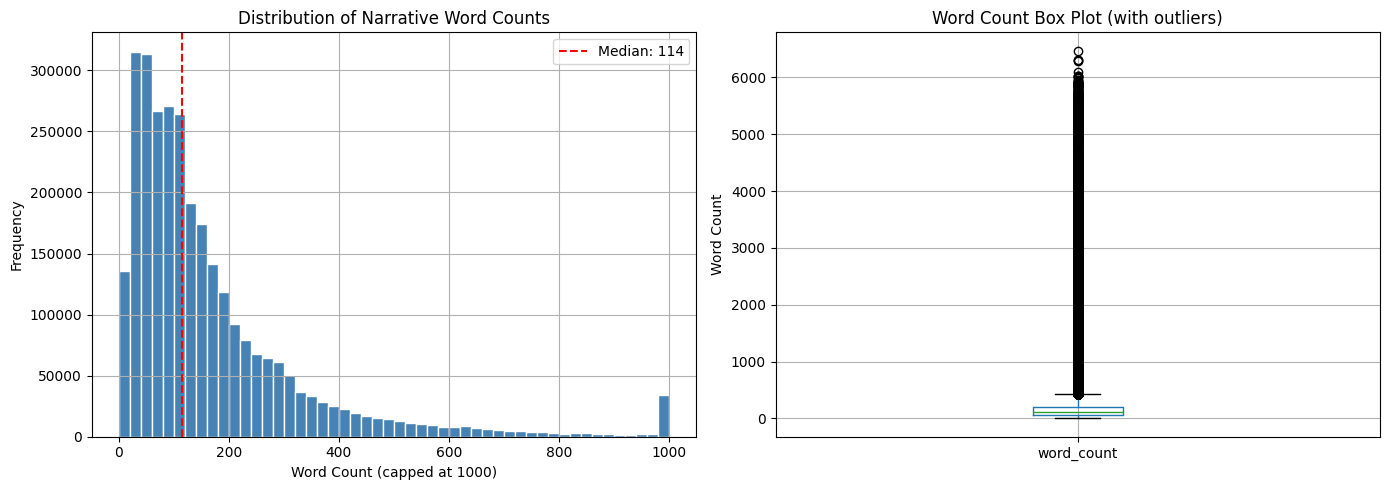

In [12]:
# Visualize word count distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram (capped at 1000 words for visibility)
ax1 = axes[0]
df_with_narrative['word_count'].clip(upper=1000).hist(bins=50, ax=ax1, color='steelblue', edgecolor='white')
ax1.set_xlabel('Word Count (capped at 1000)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Narrative Word Counts')
ax1.axvline(df_with_narrative['word_count'].median(), color='red', linestyle='--', label=f"Median: {df_with_narrative['word_count'].median():.0f}")
ax1.legend()

# Box plot
ax2 = axes[1]
df_with_narrative.boxplot(column='word_count', ax=ax2, vert=True)
ax2.set_ylabel('Word Count')
ax2.set_title('Word Count Box Plot (with outliers)')

plt.tight_layout()
plt.savefig('../notebooks/narrative_length_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Check for very short and very long narratives
print("\nExtreme narratives:")
print(f"  Very short (<10 words): {(df_with_narrative['word_count'] < 10).sum():,}")
print(f"  Short (<50 words): {(df_with_narrative['word_count'] < 50).sum():,}")
print(f"  Long (>500 words): {(df_with_narrative['word_count'] > 500).sum():,}")
print(f"  Very long (>1000 words): {(df_with_narrative['word_count'] > 1000).sum():,}")

# Sample very short narratives
print("\nSample very short narratives (<10 words):")
short_samples = df_with_narrative[df_with_narrative['word_count'] < 10]['Consumer complaint narrative'].head(5)
for i, text in enumerate(short_samples, 1):
    print(f"  {i}. {text}")


Extreme narratives:
  Very short (<10 words): 21,938
  Short (<50 words): 575,252
  Long (>500 words): 160,989
  Very long (>1000 words): 32,428

Sample very short narratives (<10 words):
  1. The following accounts are not mine and were unauthorized
  2. Credit report showing delinquency when it is not accurate.
  3. Hard inquiries that is not connected to a account
  4. My personal and financial data was compromised violating FERPA..
  5. Request validation of debt and did not receive it.


## 6. Filter Dataset to Target Products

In [14]:
print("\n" + "=" * 50)
print("FILTERING DATASET")
print("=" * 50)

# Filter to products in our mapping
target_products = list(PRODUCT_MAPPING.keys())
df_filtered = df[df['Product'].isin(target_products)].copy()
print(f"\nAfter filtering to target products: {len(df_filtered):,} rows")

# Map to standardized product names
df_filtered['product_category'] = df_filtered['Product'].map(PRODUCT_MAPPING)

# Show distribution after mapping
print(f"\nDistribution by standardized category:")
cat_counts = df_filtered['product_category'].value_counts()
for cat, count in cat_counts.items():
    print(f"  {cat}: {count:,}")


FILTERING DATASET

After filtering to target products: 1,028,614 rows

Distribution by standardized category:
  credit_card: 433,055
  savings_account: 377,383
  money_transfer: 150,420
  personal_loan: 67,756


In [15]:
# Remove empty narratives
df_filtered = df_filtered[df_filtered['Consumer complaint narrative'].fillna('').str.strip() != '']
print(f"\nAfter removing empty narratives: {len(df_filtered):,} rows")

# Final distribution
print(f"\nFinal distribution by category:")
final_counts = df_filtered['product_category'].value_counts()
for cat, count in final_counts.items():
    print(f"  {cat}: {count:,}")


After removing empty narratives: 471,668 rows

Final distribution by category:
  credit_card: 189,334
  savings_account: 155,204
  money_transfer: 98,685
  personal_loan: 28,445


## 7. Text Cleaning

In [16]:
def clean_narrative(text):
    """Clean complaint narrative text."""
    if pd.isna(text) or not isinstance(text, str):
        return ''
    
    # Lowercase
    text = text.lower()
    
    # Remove XXXX placeholders (CFPB redaction pattern)
    text = re.sub(r'x{2,}', '[REDACTED]', text)
    
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

# Apply cleaning
print("Cleaning narratives...")
df_filtered['narrative_clean'] = df_filtered['Consumer complaint narrative'].apply(clean_narrative)
print("Done!")

Cleaning narratives...
Done!


In [17]:
# Show before/after examples
print("\nCleaning examples (before -> after):")
print("=" * 80)

samples = df_filtered.sample(3, random_state=42)
for i, (_, row) in enumerate(samples.iterrows(), 1):
    original = row['Consumer complaint narrative'][:300]
    cleaned = row['narrative_clean'][:300]
    print(f"\nExample {i}:")
    print(f"BEFORE: {original}...")
    print(f"AFTER:  {cleaned}...")
    print("-" * 80)


Cleaning examples (before -> after):

Example 1:
BEFORE: I have been paying on this loan since XXXX of XXXX and it is still way too much to get it paid off. The interest rate is 66.74 % APR, I was recently informed that the interest rate since XXXX was capped at 36.00 %. So I would like to get them to decrease the interest amount to the factual per law in...
AFTER:  i have been paying on this loan since [REDACTED] of [REDACTED] and it is still way too much to get it paid off. the interest rate is 66.74 % apr, i was recently informed that the interest rate since [REDACTED] was capped at 36.00 %. so i would like to get them to decrease the interest amount to the ...
--------------------------------------------------------------------------------

Example 2:
BEFORE: I bank with navy federal and on numerous occasions my account went into overdrafts without my knowledge. Most times it will say I have money in my account then I spend and be charged overdraft fees....
AFTER:  i bank with nav

## 8. Prepare Final Dataset

In [18]:
# Select and rename columns for final output
df_final = df_filtered[[
    'Complaint ID',
    'product_category',
    'Product',
    'Sub-product',
    'Issue',
    'Sub-issue',
    'narrative_clean',
    'Company',
    'Date received'
]].copy()

# Rename columns
df_final.columns = [
    'complaint_id',
    'product',
    'product_original',
    'sub_product',
    'issue',
    'sub_issue',
    'narrative',
    'company',
    'date_received'
]

print(f"Final dataset shape: {df_final.shape}")
print(f"\nColumns: {list(df_final.columns)}")
print(f"\nSample:")
df_final.head(2)

Final dataset shape: (471668, 9)

Columns: ['complaint_id', 'product', 'product_original', 'sub_product', 'issue', 'sub_issue', 'narrative', 'company', 'date_received']

Sample:


,complaint_id,product,product_original,sub_product,issue,sub_issue,narrative,company,date_received
12237,14069121,credit_card,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,a [REDACTED] [REDACTED] card was opened under my name by a fraudster. i received a notice from [...,"CITIBANK, N.A.",2025-06-13
12532,14061897,savings_account,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,i made the mistake of using my wellsfargo debit card to depsit funds into [REDACTED] atm machine...,WELLS FARGO & COMPANY,2025-06-13


In [19]:
# Save to CSV
print(f"\nSaving to {OUTPUT_PATH}...")
df_final.to_csv(OUTPUT_PATH, index=False)
print(f"Saved! File size: {OUTPUT_PATH.stat().st_size / 1e6:.2f} MB")


Saving to ../data/filtered_complaints.csv...
Saved! File size: 653.40 MB


## 9. EDA Summary

### Key Findings

**Product Distribution:**
- [To be filled after running the notebook]

**Narrative Availability:**
- [To be filled after running the notebook]

**Narrative Length:**
- [To be filled after running the notebook]

**Filtering Results:**
- [To be filled after running the notebook]

In [20]:
# Final summary statistics
print("\n" + "=" * 50)
print("FINAL SUMMARY")
print("=" * 50)
print(f"\nOriginal dataset: {n_total:,} complaints")
print(f"After filtering to 4 product categories: {len(df_final):,} complaints")
print(f"Reduction: {(1 - len(df_final)/n_total)*100:.1f}%")
print(f"\nFinal distribution:")
for cat, count in df_final['product'].value_counts().items():
    pct = count / len(df_final) * 100
    print(f"  {cat}: {count:,} ({pct:.1f}%)")


FINAL SUMMARY

Original dataset: 9,609,797 complaints
After filtering to 4 product categories: 471,668 complaints
Reduction: 95.1%

Final distribution:
  credit_card: 189,334 (40.1%)
  savings_account: 155,204 (32.9%)
  money_transfer: 98,685 (20.9%)
  personal_loan: 28,445 (6.0%)
